<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/CNN-Architectures/blob/master/Implementations/ShuffleNet/ShuffleNet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, \
     Dense, Concatenate, Add, ReLU, BatchNormalization, AvgPool2D, \
     MaxPool2D, GlobalAvgPool2D, Reshape, Permute, Lambda, Dropout

import food_mnist

import seaborn as sns
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

from tensorflow.keras import Model

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [18]:
(x_train, y_train), (x_test, y_test) = food_mnist.load_data()
labels_names = food_mnist.labels()

In [4]:
def label(x):
    return labels_names[x]


this image is a: baby_back_ribs


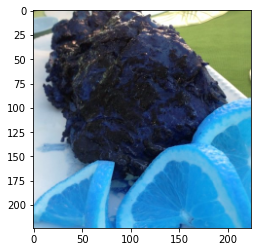

In [7]:
example = 600
g = plt.imshow(x_train[example])
print('\nthis image is a: ' + label(y_train[example]))

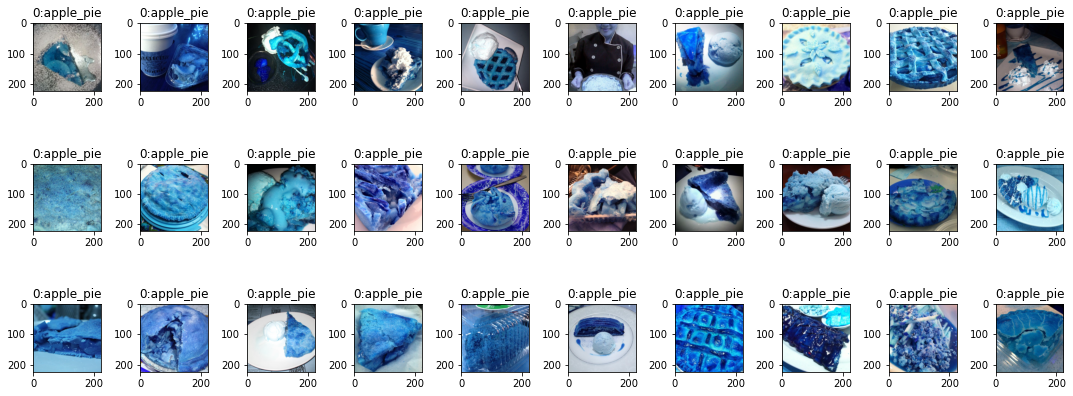

In [8]:
num_row = 3
num_col = 10
num = num_row * num_col

fig, axes = plt.subplots(num_row, num_col,
                        figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('%d:%s'%(y_train[i], labels_names[y_train[i]]))
plt.tight_layout()
plt.show()

9    375
7    375
5    375
3    375
1    375
8    375
6    375
4    375
2    375
0    375
dtype: int64

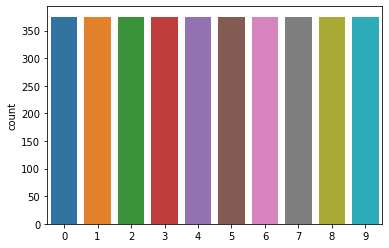

In [13]:
df = pd.Series(y_train)
g = sns.countplot(df)
df.value_counts()

In [19]:
x_train = x_train/255.
x_test = x_test/255.

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))
print(y_train[500])

number of training examples = 3750
number of test examples = 1250
X_train shape: (3750, 224, 224, 3)
Y_train shape: (3750, 10)
X_test shape: (1250, 224, 224, 3)
Y_test shape: (1250, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
def stage(x, channels, repetitions, groups):
    x = shufflenet_block(x, channels=channels, strides=2, groups=groups)
    for i in range(repetitions):
        x = shufflenet_block(x, channels=channels, strides=1, groups=groups)
    return x


def shufflenet_block(tensor, channels, strides, groups):
    x = gconv(tensor, channels=channels // 4, groups=groups)
    x = BatchNormalization()(x)
    x = ReLU()(x)
 
    x = channel_shuffle(x, groups)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
 
    if strides == 2:
        channels = channels - tensor.get_shape().as_list()[-1]
    x = gconv(x, channels=channels, groups=groups)
    x = BatchNormalization()(x)
 
    if strides == 1:
        x = Add()([tensor, x])
    else:
        avg = AvgPool2D(pool_size=3, strides=2, padding='same')(tensor)
        x = Concatenate()([avg, x])
 
    output = ReLU()(x)
    return output


def gconv(tensor, channels, groups):
    input_ch = tensor.get_shape().as_list()[-1]
    group_ch = input_ch // groups
    output_ch = channels // groups
    groups_list = []
 
    for i in range(groups):
        # group_tensor = tensor[:, :, :, i * group_ch: (i+1) * group_ch]
        group_tensor = Lambda(lambda x: x[:, :, :, i * group_ch: (i+1) * group_ch])(tensor)
        group_tensor = Conv2D(output_ch, 1)(group_tensor)
        groups_list.append(group_tensor)
 
    output = Concatenate()(groups_list)
    return output


def channel_shuffle(x, groups):  
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups
 
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x


input = Input([224, 224, 3])
x = Conv2D(filters=24, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)


repetitions = 3, 7, 3
initial_channels = 384
groups = 8
 
for i, reps in enumerate(repetitions):
    channels = initial_channels * (2**i)
    x = stage(x, channels, reps, groups)


x = GlobalAvgPool2D()(x)

output = Dense(10, activation='softmax')(x)

In [22]:
model = Model(input, output)
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# model.summary()

In [23]:
# for i,layer in enumerate(model.layers):
#   print("{}: {}".format(i,layer))

In [7]:
for layer in model.layers[:712]:
    layer.trainable=False
for layer in model.layers[712:]:
    layer.trainable=True

In [8]:
history = model.fit(x_train, y_train,
              epochs=3,
              batch_size = 224)

Epoch 1/3
17/17 [==============================] - 742s 42s/step - loss: 3.0628 - accuracy: 0.1275
Epoch 2/3
17/17 [==============================] - 750s 44s/step - loss: 2.2953 - accuracy: 0.1640
Epoch 3/3
17/17 [==============================] - 761s 45s/step - loss: 2.1376 - accuracy: 0.2299


In [9]:
ypred = model.predict(x_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\nAccurately-predicted-data:', accurate, '\nWrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 1250 
Accurately-predicted-data: 125 
Wrongly-predicted-data:  1125
Accuracy: 10.0 %
